In [39]:
from typing import TypedDict,Annotated,Optional
from langgraph.graph import add_messages,StateGraph,END
from dotenv import load_dotenv
from langchain_groq import ChatGroq
from langchain_tavily import TavilySearch
from langgraph.checkpoint.memory import MemorySaver
from uuid import uuid4
import json
from rich import print as print

load_dotenv()

model=ChatGroq(model="llama-3.1-8b-instant",streaming=True)

response=model.invoke("give me a joke about cats")
print(response)

AIMessage(
    content='Why did the cat join a band?\n\nBecause it wanted to be the purr-cussionist.',
    additional_kwargs={},
    response_metadata={
        'finish_reason': 'stop',
        'model_name': 'llama-3.1-8b-instant',
        'system_fingerprint': 'fp_c54ae48ece',
        'service_tier': 'on_demand'
    },
    id='run--b2f41d59-9ea4-405d-b043-a39d20f3f381-0',
    usage_metadata={'input_tokens': 41, 'output_tokens': 21, 'total_tokens': 62}
)

In [40]:
search_tool = TavilySearch(max_results=2)
tools = [search_tool]

memory=MemorySaver()



In [41]:
llm_with_tools=model.bind_tools(tools=tools)


In [42]:
from langchain_core.messages import AIMessage,HumanMessage,ToolMessage
class State(TypedDict):
    messages:Annotated[list,add_messages]
    
async def model (state :State):
    result=await llm_with_tools.ainvoke(state["messages"])
    return{"messages":[result],}

async def tools_router(state:State):
    last_message=state["messages"][-1]
    
    if (hasattr(last_message,"tool_calls") and len(last_message.tool_calls)>0):
        return "tool_node"
    else:
        return END
    
async def tool_node(state):
    """custom tool node that handles tool calls from the LLM."""
    #Get the tool calls from the last message 
    tool_calls =state["messages"][-1].tool_calls
    
    # intialize lost to store tools messages 
    tool_messages=[]
    
    ##process each tool call
    for tool_call in tool_calls:
        tool_name=tool_call["name"]
        tool_args=tool_call["args"]
        tool_id=tool_call["id"]
        
    #handel the search tool 
    if tool_name== "tavily_search":
        #excecute the search tools with the provided arguments
        search_results=await search_tool.ainvoke(tool_args)
        
        #create a tool message for this result
        tool_message=ToolMessage(
            content=str(search_results),
            tool_call_id=tool_id,name=tool_name
        )
        
        tool_messages.append(tool_message)
    #add the tool meessages to the state
    return {"messages":tool_messages}

graph_builder=StateGraph(State)
graph_builder.add_node("model",model)
graph_builder.add_node("tool_node",tool_node)
graph_builder.set_entry_point("model")

graph_builder.add_conditional_edges("model",tools_router)
graph =graph_builder.compile (checkpointer=memory)
    
        
        
    
    
    
    

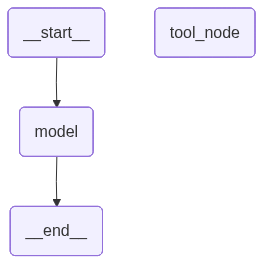

In [43]:
from IPython.display import Image,display
from langchain_core.runnables.graph import MermaidDrawMethod

display(
    Image(
        graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API
        )
    )
)

In [56]:
config={"configurable":{"thread_id":82}}
response=await graph.ainvoke({
    "messages":[HumanMessage(content="when is the thenext space x launch")]
},config=config)
response

{'messages': [HumanMessage(content='when is the thenext space x launch', additional_kwargs={}, response_metadata={}, id='59d3848a-bae4-46e5-ab36-9bcea417ee4f'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'index': 0, 'id': '249t7c8mr', 'function': {'arguments': '{"query":"next space x launch","search_depth":"advanced","topic":"news"}', 'name': 'tavily_search'}, 'type': 'function'}]}, response_metadata={'finish_reason': 'tool_calls', 'model_name': 'llama-3.1-8b-instant', 'system_fingerprint': 'fp_c54ae48ece', 'service_tier': 'on_demand'}, id='run--1325b903-abab-4bb2-b62a-254ba05b9c93-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'next space x launch', 'search_depth': 'advanced', 'topic': 'news'}, 'id': '249t7c8mr', 'type': 'tool_call'}], usage_metadata={'input_tokens': 1220, 'output_tokens': 32, 'total_tokens': 1252}),
  ToolMessage(content="{'query': 'next space x launch', 'follow_up_questions': None, 'answer': None, 'images': [], 'results': [{'url': 'https

In [46]:

config={"configurable":{"thread_id":898}}
async for event in graph.astream_events({
    "messages":[HumanMessage(content="when is the thenext space x launch")]
},config=config,version="v2"):
    if event["event"] not in ["onchain_strem","o_chain_end"]:
        print(event,end="\n",flush=True,)
print 

{
    'event': 'on_chain_start',
    'data': {
        'input': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={}
                )
            ]
        }
    },
    'name': 'LangGraph',
    'tags': [],
    'run_id': '47320f25-dc18-4b0c-bcf9-8e0839687785',
    'metadata': {'thread_id': 898},
    'parent_ids': []
}

{
    'event': 'on_chain_start',
    'data': {
        'input': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={},
                    id='b99418db-e2a6-4d0b-bf6b-b317727c05b8'
                )
            ]
        }
    },
    'name': 'model',
    'tags': ['graph:step:1'],
    'run_id': 'a3524e5f-7c60-4941-b995-7ee88cd48711',
    'metadata': {
        'thread_id': 898,
        'langgraph_step': 1,
        'langgraph_node': 'model',
        'langgraph_triggers': ('branch:to:model',),
        'langgraph_path': ('__pregel_pull', 'model'),
        'langgraph_checkpoint_ns': 'model:552a04d0-8132-239e-829d-10d21c3688a1'
    },
    'parent_ids': ['47320f25-dc18-4b0c-bcf9-8e0839687785']
}

{
    'event': 'on_chain_start',
    'data': {
        'input': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={},
                    id='b99418db-e2a6-4d0b-bf6b-b317727c05b8'
                ),
                AIMessage(
                    content='<function=t',
                    additional_kwargs={},
                    response_metadata={
                        'finish_reason': 'stop',
                        'model_name': 'llama-3.1-8b-instant',
                        'system_fingerprint': 'fp_28116a6b5f',
                        'service_tier': 'on_demand'
                    },
                    id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                    usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                )
            ]
        }
    },
    'name': 'tools_router',
    'tags': ['seq:step:3'],
    'run_id': '14101c21-8e02-4130-bd63-59145cdf1249',
    'metadata': {
        'thread_id': 898,
        'langgraph_step': 1,
        'langgraph_node': 'model',
        'langgraph_triggers': ('branch:to:model',),
        'langgraph_path': ('__pregel_pull', 'model'),
        'langgraph_checkpoint_ns': 'model:552a04d0-8132-239e-829d-10d21c3688a1'
    },
    'parent_ids': ['47320f25-dc18-4b0c-bcf9-8e0839687785', 'a3524e5f-7c60-4941-b995-7ee88cd48711']
}

{
    'event': 'on_chain_end',
    'data': {
        'output': '__end__',
        'input': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={},
                    id='b99418db-e2a6-4d0b-bf6b-b317727c05b8'
                ),
                AIMessage(
                    content='<function=t',
                    additional_kwargs={},
                    response_metadata={
                        'finish_reason': 'stop',
                        'model_name': 'llama-3.1-8b-instant',
                        'system_fingerprint': 'fp_28116a6b5f',
                        'service_tier': 'on_demand'
                    },
                    id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                    usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                )
            ]
        }
    },
    'run_id': '14101c21-8e02-4130-bd63-59145cdf1249',
    'name': 'tools_router',
    'tags': ['seq:step:3'],
    'metadata': {
        'thread_id': 898,
        'langgraph_step': 1,
        'langgraph_node': 'model',
        'langgraph_triggers': ('branch:to:model',),
        'langgraph_path': ('__pregel_pull', 'model'),
        'langgraph_checkpoint_ns': 'model:552a04d0-8132-239e-829d-10d21c3688a1'
    },
    'parent_ids': ['47320f25-dc18-4b0c-bcf9-8e0839687785', 'a3524e5f-7c60-4941-b995-7ee88cd48711']
}

{
    'event': 'on_chain_stream',
    'run_id': 'a3524e5f-7c60-4941-b995-7ee88cd48711',
    'name': 'model',
    'tags': ['graph:step:1'],
    'metadata': {
        'thread_id': 898,
        'langgraph_step': 1,
        'langgraph_node': 'model',
        'langgraph_triggers': ('branch:to:model',),
        'langgraph_path': ('__pregel_pull', 'model'),
        'langgraph_checkpoint_ns': 'model:552a04d0-8132-239e-829d-10d21c3688a1'
    },
    'data': {
        'chunk': {
            'messages': [
                AIMessage(
                    content='<function=t',
                    additional_kwargs={},
                    response_metadata={
                        'finish_reason': 'stop',
                        'model_name': 'llama-3.1-8b-instant',
                        'system_fingerprint': 'fp_28116a6b5f',
                        'service_tier': 'on_demand'
                    },
                    id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                    usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                )
            ]
        }
    },
    'parent_ids': ['47320f25-dc18-4b0c-bcf9-8e0839687785']
}

{
    'event': 'on_chain_end',
    'data': {
        'output': {
            'messages': [
                AIMessage(
                    content='<function=t',
                    additional_kwargs={},
                    response_metadata={
                        'finish_reason': 'stop',
                        'model_name': 'llama-3.1-8b-instant',
                        'system_fingerprint': 'fp_28116a6b5f',
                        'service_tier': 'on_demand'
                    },
                    id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                    usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                )
            ]
        },
        'input': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={},
                    id='b99418db-e2a6-4d0b-bf6b-b317727c05b8'
                )
            ]
        }
    },
    'run_id': 'a3524e5f-7c60-4941-b995-7ee88cd48711',
    'name': 'model',
    'tags': ['graph:step:1'],
    'metadata': {
        'thread_id': 898,
        'langgraph_step': 1,
        'langgraph_node': 'model',
        'langgraph_triggers': ('branch:to:model',),
        'langgraph_path': ('__pregel_pull', 'model'),
        'langgraph_checkpoint_ns': 'model:552a04d0-8132-239e-829d-10d21c3688a1'
    },
    'parent_ids': ['47320f25-dc18-4b0c-bcf9-8e0839687785']
}

{
    'event': 'on_chain_stream',
    'run_id': '47320f25-dc18-4b0c-bcf9-8e0839687785',
    'name': 'LangGraph',
    'tags': [],
    'metadata': {'thread_id': 898},
    'data': {
        'chunk': {
            'model': {
                'messages': [
                    AIMessage(
                        content='<function=t',
                        additional_kwargs={},
                        response_metadata={
                            'finish_reason': 'stop',
                            'model_name': 'llama-3.1-8b-instant',
                            'system_fingerprint': 'fp_28116a6b5f',
                            'service_tier': 'on_demand'
                        },
                        id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                        usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                    )
                ]
            }
        }
    },
    'parent_ids': []
}

{
    'event': 'on_chain_end',
    'data': {
        'output': {
            'messages': [
                HumanMessage(
                    content='when is the thenext space x launch',
                    additional_kwargs={},
                    response_metadata={},
                    id='b99418db-e2a6-4d0b-bf6b-b317727c05b8'
                ),
                AIMessage(
                    content='<function=t',
                    additional_kwargs={},
                    response_metadata={
                        'finish_reason': 'stop',
                        'model_name': 'llama-3.1-8b-instant',
                        'system_fingerprint': 'fp_28116a6b5f',
                        'service_tier': 'on_demand'
                    },
                    id='run--0b8bb819-4544-416b-9243-ac03ea472175-0',
                    usage_metadata={'input_tokens': 1220, 'output_tokens': 22, 'total_tokens': 1242}
                )
            ]
        }
    },
    'run_id': '47320f25-dc18-4b0c-bcf9-8e0839687785',
    'name': 'LangGraph',
    'tags': [],
    'metadata': {'thread_id': 898},
    'parent_ids': []
}

<function rich.print(*objects: Any, sep: str = ' ', end: str = '\n', file: Optional[IO[str]] = None, flush: bool = False) -> None>

In [ ]:
config = {"configurable": {"thread_id": 9089}}
        # Continue existing conversation
async for event in graph.astream_events({
    "messages":[HumanMessage(content="when is the thenext space x launch")]
},config=config,version="v2"):
        print(event.)